In [1]:
import nltk
import numpy as np
from sklearn.datasets import fetch_20newsgroups

from random import shuffle
from collections import OrderedDict 

import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer

In [2]:
# TODO TRY fetch_20newsgroups(subset='train',categories=categories, remove=('headers', 'footers', 'quotes'))

# Preprocessing

In [3]:
# return dataset and labels as np arrays
def get_dataset(n_samples_per_cat: int):
    categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
            
    data = np.array([])
    labels = np.array([])
    current_label = 0
    
    for category in categories:
        ng_category = fetch_20newsgroups(subset='all', shuffle=False, categories=[category])
        
        # add post contents to dataset
        ng_category_contents = ng_category.data[:n_samples_per_cat]
        data = np.append(data, ng_category_contents)
        
        # target attribute is the integer index of the category
        labels = np.append(labels, [current_label for x in range(0, len(ng_category_contents))])
        current_label += 1

    # shuffle elements in dataset
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data = np.array(data)[indices]
    labels = np.array(labels)[indices]
   
    return data, labels

In [55]:
# returns cleaned tokens specified by cleaning params
def preprocessing(text, stem=False, stop=False, sent=False):
    
    # Remove punctuations
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
    
 
    tokens = word_tokenize(text)
    
    if stop:
        stop = stopwords.words('english')
        tokens =[word for word in tokens if word not in stop]
        tokens = [word.lower() for word in tokens]

#     if stem:
#         stemmer = PorterStemmer()
#         tokens = [stemmer.stem(t) for t in tokens]
    
#     if sent:
#         tokens = ' '.join(tokens)
        
    return tokens

# preprocessing news articles for Doc2Vec 
def clean_news(docs):
    
    clean = []
    
    for doc in docs:
        clean.append(preprocessing(doc,stop=True,sent=False, stem=False))

    return clean

In [56]:
articles, labels = get_dataset(500)

In [61]:
articles_clean = clean_news(articles)

# Build doc2vec models

In [8]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec

from collections import OrderedDict
import multiprocessing
from gensim.models.doc2vec import TaggedDocument
from gensim.models.callbacks import CallbackAny2Vec

import sys

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

from collections import namedtuple
import nltk
from gensim.models.doc2vec import  LabeledSentence
import sys
from os import listdir

NewsgroupDocument = namedtuple('NewsGroupDocument', 'words tags category')

In [9]:
# return articles in format expected by doc2vec i.e. list of tagged documents
def convert_to_doc2vec_format(docs, doc_labels):
    tagged_docs = []
    
    for doc_id, doc_contents in enumerate(docs):
        tagged_docs.append(NewsgroupDocument(doc_contents, [doc_id+1], doc_labels[doc_id]))
        
    return tagged_docs

In [10]:
def generate_doc2vec_model(tagged_documents, model_name):
    parameters=dict(dm=0,
                    vector_size=100,
                    epochs=20,
                    min_count=4,
                    workers=multiprocessing.cpu_count(),
                    negative=5,
                    hs=0,
                    sample=0,
                    )

    path_to_models = 'models/'
    if model_name in listdir(path_to_models):
        print("Overwrite danger! CHANGE MODEL NAME!")
    else:
        train_doc2vec(model_name=model_name, documents=tagged_documents, parameters=parameters)

In [59]:
# convert all posts to tagged documents
tagged_docs = convert_to_doc2vec_format(docs=articles_clean, doc_labels=labels)

generate_doc2vec_model(tagged_docs, 'model_4.model')

Epoch #0 #1 #2 #3 #4 #5 #6 #7 #8 #9 #10 #11 #12 #13 #14 #15 #16 #17 #18 #19 
trained doc2vec model!


https://github.com/skillachie/nlpArea51/blob/master/doc2vec/20%20NewsGroups%20Text%20Classification%20With%20Doc2Vec.ipynb

In [33]:
import matplotlib.patheffects as PathEffects
from gensim.models.doc2vec import Doc2Vec
import numpy as np
from sklearn.manifold import TSNE

# Utility function to visualize the outputs of t-SNE
def draw_scatter(tsne_coords, colours):
    #choose colour palette with seaborn
    num_classes = len(np.unique(colours))
    assert num_classes == 20
    palette = np.array(sns.color_palette("hls", num_classes))
        
    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(tsne_coords[:,0], tsne_coords[:,1], lw=0, s=40, c=palette[colours.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    
    plt.title('My title')

    ax.axis('off')
    ax.axis('tight')
    
    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(tsne_coords[colours == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=10)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
  

def infer_all_vectors(tagged_docs, model_name):
    X = []

    model = Doc2Vec.load('models/' + model_name)
    for doc in tagged_docs:
        X.append(model.infer_vector(doc.words))
    X = np.asarray(X)
    
    return X

# returns the x,y coordinates the data as well as the target colours
def generate_tsne_data(X):
#     X = []

#     model = Doc2Vec.load('models/model_1.model')
#     for doc in tagged_docs:
#         X.append(model.infer_vector(doc.words))
#     X = np.asarray(X)
    x = TSNE(n_components=2).fit_transform(X)

    colours = np.asarray([int(tagged_docs[i].category) for i in range(0, len(tagged_docs))])
    
    return x, colours

# generate t_sne and draw graph
def draw(X):
    tsne_coords, colours = generate_tsne_data(X)
    draw_scatter(tsne_coords, colours)
    

In [62]:
from sklearn.decomposition import PCA

X = infer_all_vectors(tagged_docs, 'model_4.model')

In [50]:
# Create a PCA that will retain 99% of the variance
# pca = PCA(whiten=True)

# Conduct PCA
# X_pca = pca.fit_transform(X)

In [51]:
# # Show results
# print('Original number of features:', X.shape[1])
# print('Reduced number of features:', X_pca.shape[1])

Original number of features: 100
Reduced number of features: 100


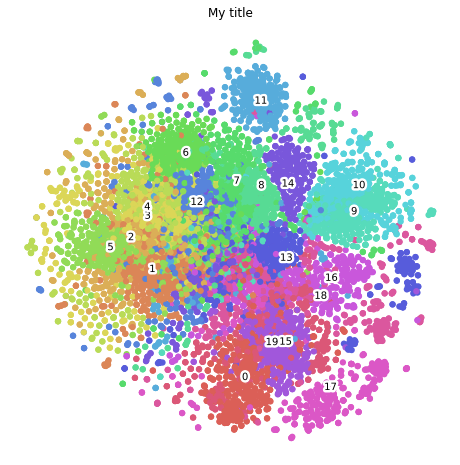

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns
draw(X)

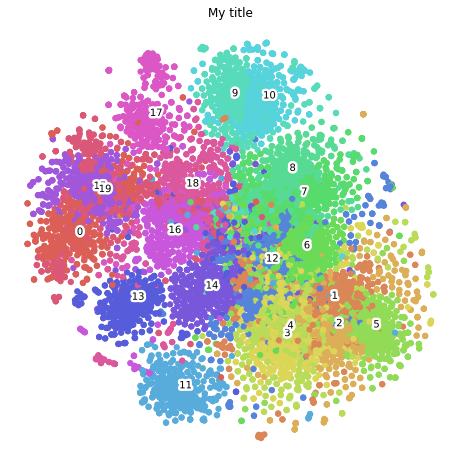

In [63]:
from matplotlib import pyplot as plt
import seaborn as sns
draw(X)

# misc

In [180]:
# tagged_docs .words .tags .category
# want to plot infered vectors and colour by category

In [ ]:
# import seaborn as sns

# # We choose a color palette with seaborn
# palette = np.array(sns.color_palette("hls", 200))

# # We create a scatter plot.
# f = plt.figure(figsize=(8, 8))
# ax = plt.subplot(aspect='equal')
# sc = ax.scatter(x=x[:,0], y=x[:,1], lw=0, s=40,
#                 c=palette)
# plt.xlim(-25, 25)
# plt.ylim(-25, 25)
# ax.axis('off')
# ax.axis('tight')